In [94]:
import os

import pickle
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

import matplotlib.pyplot as plt

In [85]:
df = pd.read_csv(r"C:\Users\furka\Desktop\ain4311\project\real-time-motion-detector\data\geophone-sensor-data.csv")
sequence_length = 3

In [86]:
df.head()

,timestamp,mean,top_3_mean,min,max,std_dev,median,q1,q3,skewness,dominant_freq,energy,activity,name
0,01:51:43,2046.726000,2057.666667,2035,2060,3.452186,2047.0,2043.0,2049.0,-0.152574,601.0,1.988682e+09,walking,Yusuf
1,01:51:46,2046.619333,2053.000000,2040,2053,3.580469,2047.0,2044.0,2050.0,-0.150615,300.0,1.988028e+09,walking,Yusuf
2,01:51:50,2046.598000,2056.000000,2030,2059,3.592826,2047.0,2044.0,2049.0,-0.370125,300.0,1.987897e+09,walking,Yusuf
3,01:51:53,2046.560000,2054.000000,2039,2055,3.414830,2047.0,2044.0,2049.0,-0.321296,300.0,1.987662e+09,walking,Yusuf
4,01:51:56,2046.656667,2055.000000,2034,2057,3.356802,2048.0,2044.0,2049.0,-0.379134,300.0,1.988255e+09,walking,Yusuf


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      1800 non-null   object 
 1   mean           1800 non-null   float64
 2   top_3_mean     1800 non-null   float64
 3   min            1800 non-null   int64  
 4   max            1800 non-null   int64  
 5   std_dev        1800 non-null   float64
 6   median         1800 non-null   float64
 7   q1             1800 non-null   float64
 8   q3             1800 non-null   float64
 9   skewness       1800 non-null   float64
 10  dominant_freq  1800 non-null   float64
 11  energy         1800 non-null   float64
 12  activity       1800 non-null   object 
 13  name           1800 non-null   object 
dtypes: float64(9), int64(2), object(3)
memory usage: 197.0+ KB


# Data Preprocessing

In [88]:
def preprocess_data(dataframe, sequence_length):
    # Label the 'name' column
    label_encoder = LabelEncoder()
    dataframe['name_encoded'] = label_encoder.fit_transform(dataframe['name'])
    
    # Split the feature and target variables
    features = dataframe.drop(columns = ['timestamp', 'name', 'name_encoded', 'activity']).values
    target = dataframe['name_encoded'].values
    
    # Scaling numeric features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    
    X, y = [], []
    for i in range(sequence_length, len(scaled_features)):
        X.append(scaled_features[i-sequence_length:i])
        y.append(target[i])
    
    X, y = np.array(X), np.array(y)
    
    # Save the scaler and label_encoder
    config_path = r'C:\Users\furka\Desktop\ain4311\project\real-time-motion-detector\config'
    
    # Save the scaler
    scaler_path = os.path.join(config_path, 'scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    # Save the label_encoder
    label_encoder_path = os.path.join(config_path, 'label_encoder.pkl')
    with open(label_encoder_path, 'wb') as f:
        pickle.dump(label_encoder, f)

    return X, y, scaler, label_encoder

In [89]:
def create_lstm_model(input_shape, num_classes):
    
    model_dir = "../models/"
    model_version = 1
    
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    save_model_with_version( model = model,
                             model_dir = model_dir,
                             name = "fs_model_lstm_v5.h5")
    
    return model

In [90]:
def save_model_with_version(model, model_dir, name):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_version = len(os.listdir(model_dir)) + 1

    model_version_dir = os.path.join(model_dir, str(model_version))
    if not os.path.exists(model_version_dir):
        os.makedirs(model_version_dir)

    model.save(os.path.join(model_version_dir, name))

In [91]:
def plot_training_history(history):
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.legend()
    plt.show()

In [95]:
X, y, scaler, label_encoder = preprocess_data(df, sequence_length)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [97]:
# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y))
model = create_lstm_model(input_shape, num_classes)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 3, 64)          │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,485 (126.89 KB)

 Trainable params: 32,485 (126.89 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
history = model.fit(X_train, y_train, epochs=50, batch_size=2, validation_split=0.2, verbose=1)

Epoch 1/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3930 - loss: 1.3083 - val_accuracy: 0.6007 - val_loss: 0.8906
Epoch 2/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5984 - loss: 0.8995 - val_accuracy: 0.5903 - val_loss: 0.8499
Epoch 3/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5817 - loss: 0.8779 - val_accuracy: 0.6771 - val_loss: 0.7916
Epoch 4/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6474 - loss: 0.8411 - val_accuracy: 0.6701 - val_loss: 0.7730
Epoch 5/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6226 - loss: 0.8201 - val_accuracy: 0.6806 - val_loss: 0.7393
Epoch 6/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6797 - loss: 0.7455 - val_accuracy: 0.6528 - val_loss: 0.8133
Epoch 7/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6700 - loss: 0.7391 - val_accuracy: 0.7014 - val_loss: 0.7155
Epoch 8/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6696 - loss: 0.6988 - val_accuracy: 0.

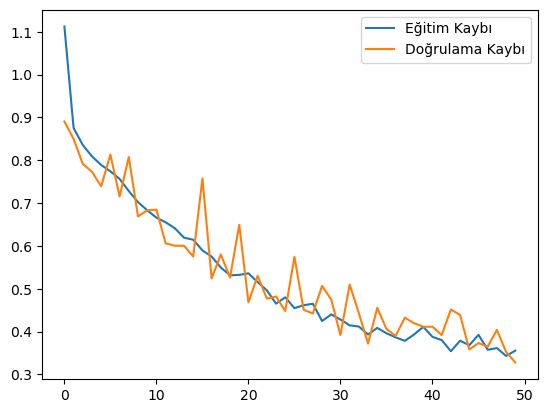

In [99]:
plot_training_history(history)

In [100]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.3154961168766022
Test Accuracy: 0.8777777552604675


In [80]:
def predict_new_data(model, new_data, scaler, label_encoder):
    new_data = scaler.transform(new_data)  # Ölçeklendirme
    new_data = np.expand_dims(new_data, axis=0)  # LSTM için uygun format
    prediction = model.predict(new_data)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

In [81]:
print("X shape:", X.shape)  # X'in boyutlarını kontrol et
print("y shape:", y.shape)  # y'nin boyutlarını kontrol et

X shape: (1797, 3, 11)
y shape: (1797,)


In [83]:
num_classes = len(label_encoder.classes_)
num_classes

5

In [103]:
import sklearn
print(sklearn.__version__)

1.2.1
